In [1]:
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
print('torch.__version__',torch.__version__)
print('torch.cuda.is_available?',torch.cuda.is_available())

torch.__version__ 2.1.0+cu121
torch.cuda.is_available? True


In [2]:
import torchvision
import torch
from torch.utils.data import DataLoader,Dataset,TensorDataset
from torchvision import transforms,datasets
from argparse import Namespace

In [3]:
config=Namespace(batch_size=16,
                num_epochs=20,
                lr=1e-4,
                image_size=224,
                train_path=r"Flacc/train",
                val_path=r"Flacc/val/"
                )

In [4]:
def transforms_labels(x):
    return torch.tensor(x,dtype=torch.int64)

In [5]:
transforms_val=transforms.Compose([transforms.Resize((config.image_size,config.image_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=(0.0,0.0,0.0),
                                                        std=(1.0,1.0,1.0))])

In [6]:
ds_val=datasets.ImageFolder(config.val_path,
                             transforms_val,
                             target_transform=transforms_labels)

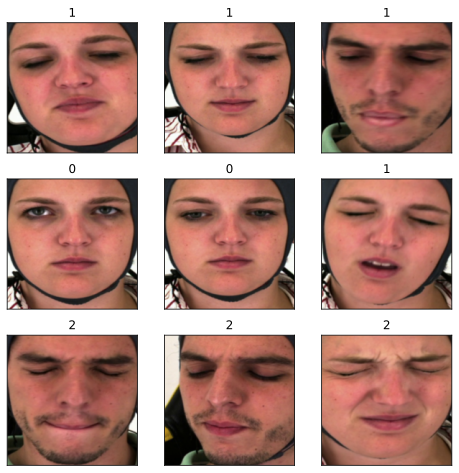

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8,8)) 
idxes = np.random.choice(range(len(ds_val)),9)
#随机选择9张图片展示
class_names=ds_val.classes
for i in range(9):
    idx = idxes[i]
    img,label = ds_val[idx]
#     print(label)
    img = img.permute(1,2,0)#交换维度，转成rgb
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title(f"{class_names[label.int().item()]}")
    #label.int().item()获取标号
    ax.set_xticks([])
    ax.set_yticks([]) #坐标刻度
plt.show()

In [8]:
import torch.nn as nn
#可以通过stride控制feature map的size
class Residual(nn.Module):
    def __init__(self,input_channels,num_channels,
                 use_1x1conv=False,strides=1):
        super(Residual,self).__init__()
        self.Conv2d_layer1=nn.Conv2d(input_channels,num_channels,
                                     kernel_size=3,
                                     padding=1,
                                     stride=strides)
        self.BatchNorm2d_layer1=nn.BatchNorm2d(num_channels)
        self.ReLU=nn.ReLU()
        self.Conv2d_layer2=nn.Conv2d(num_channels,num_channels,
                                     kernel_size=3,
                                     padding=1)#第二个卷积是没有步长的
        if use_1x1conv:
            self._1x1Conv = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self._1x1Conv = None
        self.BatchNorm2d_layer2=nn.BatchNorm2d(num_channels)
        self.Dropout=nn.Dropout(p=0.1)
    def forward(self,x):
        y=self.Conv2d_layer1(x)
        y=self.BatchNorm2d_layer1(y)
        y=self.ReLU(y)
        y=self.Conv2d_layer2(y)
        y=self.BatchNorm2d_layer2(y)
        if self._1x1Conv:
            x = self._1x1Conv(x)
        y+=x
        y=self.ReLU(y)
        return y

In [9]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    #输入，输出，残差数，是否是第一个resnet块
    blk = []
    
    for i in range(num_residuals):
        #是第一个残差块且不是第一个 ResNet 块，即block2,3,4的第一个残差块
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [10]:
block1 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
block2 = nn.Sequential(*resnet_block(64, 128, 2))
block3 = nn.Sequential(*resnet_block(128, 256, 2))
block4 = nn.Sequential(*resnet_block(256, 512, 2))

In [11]:
import torch.nn as nn
input_block=nn.Sequential(nn.Conv2d(3,64,kernel_size=7,
                                    padding=2,stride=4),
                         nn.BatchNorm2d(64),
                         nn.ReLU(),
                         nn.MaxPool2d(kernel_size=3,stride=2,padding=1))


In [12]:
ResNet4 = nn.Sequential(input_block, 
                        block1, 
                        block2, 
                        block3, 
                        block4,
                        nn.AdaptiveAvgPool2d((1,1)),#平均池化
                        nn.Flatten(), 
                        nn.Linear(512, 3)
                       )

In [13]:
import torchvision
import torch.optim as optim
from torchmetrics import Accuracy
import torch.nn as nn

net=ResNet4
# net=ResNet18
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(net.parameters(),lr=config.lr)
metrics_dict={'acc':Accuracy(task='multiclass',num_classes=3)}

In [14]:
import torchkeras
from torchkeras import KerasModel
model=KerasModel(net=net,
                loss_fn=loss_fn,
                optimizer=optimizer,
                metrics_dict=metrics_dict
                )

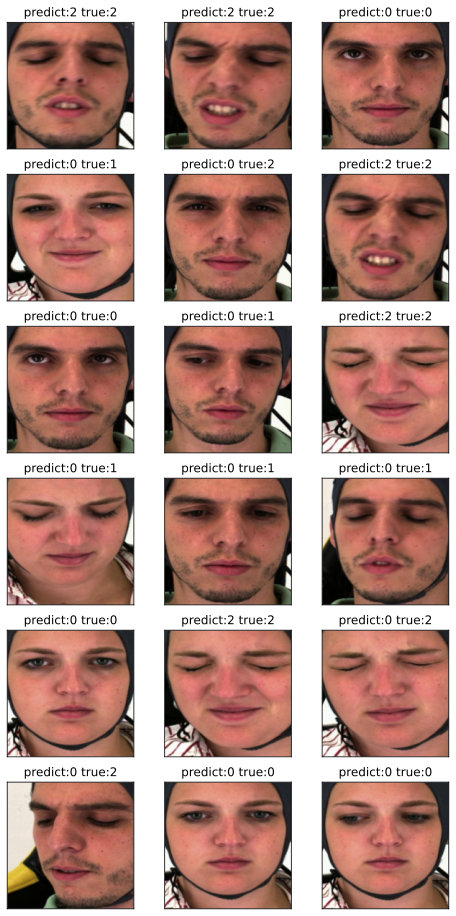

In [18]:
#加载训练好的模型
ckpt_path=r'checkpoint.pt'
model.load_ckpt(ckpt_path=ckpt_path)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# net.eval();
plt.figure(figsize=(8, 16))
idxes = np.random.choice(range(len(ds_val)), 18)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(18):
    idx = idxes[i]
    img, label = ds_val[idx]
    tensor = img.unsqueeze(dim=0)
    output = model.forward(tensor)
    _, predicted_class = output.max(1)
    predicted_class = predicted_class.item()
    ax = plt.subplot(6, 3, i + 1)
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.set_title(f"predict:{class_names[predicted_class]} true:{label}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [20]:
from PIL import Image
class_names=ds_val.classes
def predict(image_path,model):
    image = Image.open(image_path)
    image_tensor = transforms_val(image).unsqueeze(dim=0)
    output = model.forward(image_tensor)
    _, predicted_class = output.max(1)
    return class_names[predicted_class]

image_path=r"Flacc/val/1/000_1714138259585366.jpeg"
print(predict(image_path,model))

2
